Polar Sea Ice Prediction Prediction using:

Ensemble LSTM-GBR Model with Polynomial Features and Attention Mechanism .

1.   Added Gradient Boosting Regressor for ensemble learning.
2.   Introduced polynomial features.
3.   Applied L2 regularization in LSTM layers.
4.   Employed advanced optimization callbacks.





In [ ]:
from numpy.random import seed
seed(1)


In [ ]:
# Install latest attention package
!pip install attention

In [ ]:
import os
import math
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from attention import Attention
from keras.layers import Dense, Dropout, LSTM, TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1, 11)]           0         
                                                                 
 lstm_25 (LSTM)              (None, 1, 64)             19456     
                                                                 
 dropout_8 (Dropout)         (None, 1, 64)             0         
                                                                 
 lstm_26 (LSTM)              (None, 1, 32)             12416     
                                                                 
 lstm_27 (LSTM)              (None, 1, 16)             3136      
                                                                 
 attention_8 (Attention)     (None, 32)                1280      
                                                                 
 dense_25 (Dense)            (None, 32)                1056

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 - 0s - loss: 1.5579 - val_loss: 1.2555 - lr: 0.0010 - 343ms/epoch - 11ms/step
Epoch 3/300
32/32 - 0s - loss: 0.9062 - val_loss: 0.9954 - lr: 0.0010 - 451ms/epoch - 14ms/step
Epoch 4/300
32/32 - 1s - loss: 0.6662 - val_loss: 0.8088 - lr: 0.0010 - 522ms/epoch - 16ms/step
Epoch 5/300
32/32 - 0s - loss: 0.5166 - val_loss: 0.6118 - lr: 0.0010 - 498ms/epoch - 16ms/step
Epoch 6/300
32/32 - 1s - loss: 0.4227 - val_loss: 0.6076 - lr: 0.0010 - 531ms/epoch - 17ms/step
Epoch 7/300
32/32 - 1s - loss: 0.3663 - val_loss: 0.5320 - lr: 0.0010 - 508ms/epoch - 16ms/step
Epoch 8/300
32/32 - 1s - loss: 0.3123 - val_loss: 0.4431 - lr: 0.0010 - 541ms/epoch - 17ms/step
Epoch 9/300
32/32 - 0s - loss: 0.2873 - val_loss: 0.5220 - lr: 0.0010 - 428ms/epoch - 13ms/step
Epoch 10/300
32/32 - 1s - loss: 0.2626 - val_loss: 0.4363 - lr: 0.0010 - 564ms/epoch - 18ms/step
Epoch 11/300
32/32 - 1s - loss: 0.2438 - val_loss: 0.4129 - lr: 0.0010 - 503ms/epoch - 16ms/step
Epoch 12/300
32/32 - 0s - loss: 0.2123 - val_loss:

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1/1 [==============================] - 0s 29ms/step
Test RMSE: 1112026.660
Test NRMSE: 0.10589872514985921
Test R_Square: 0.903


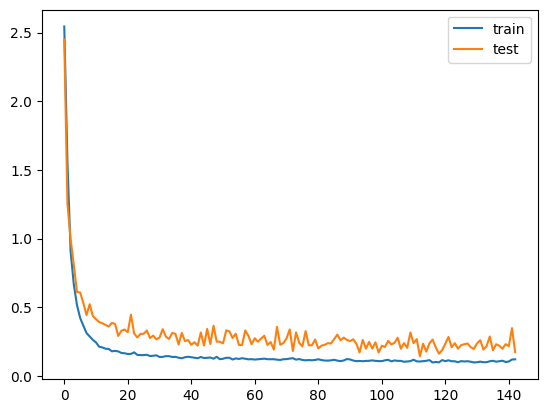

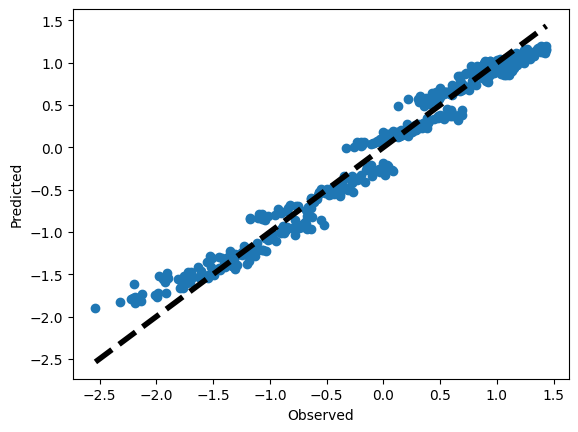

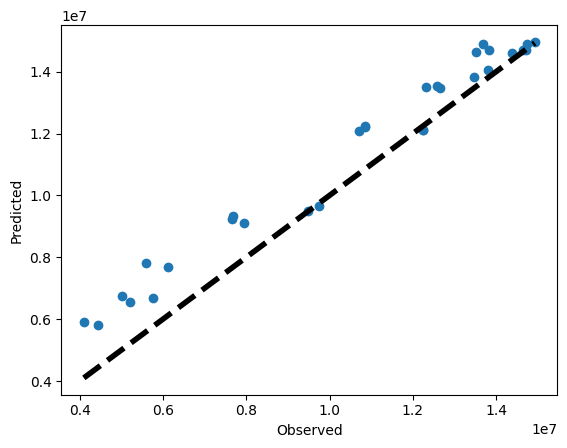

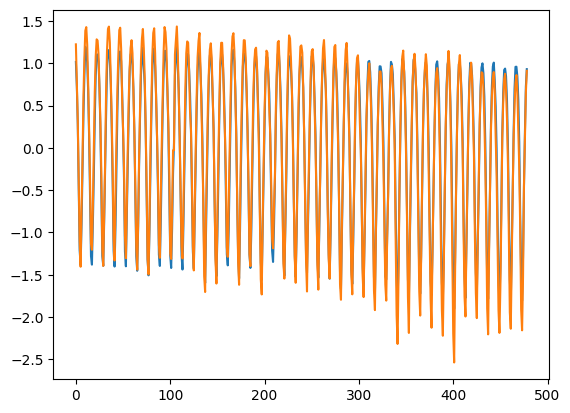

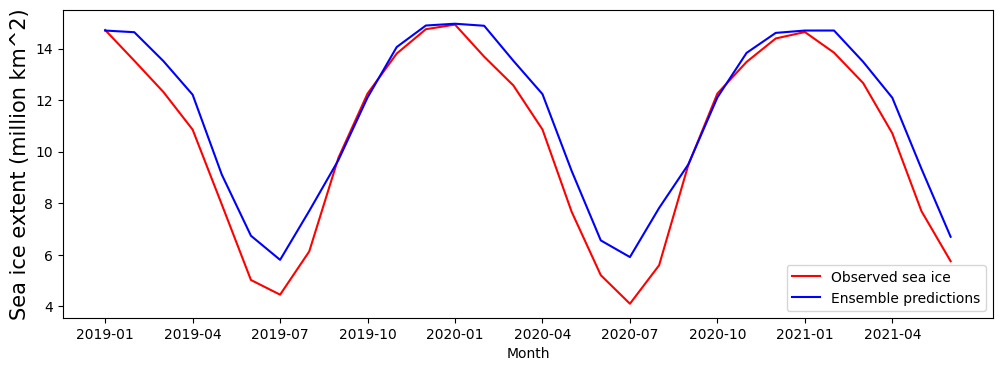

In [28]:

# Loading Combined Data 1979-2021
df = pd.read_csv('Arctic_domain_mean_monthly_1979_2021.csv')
df = df.drop(['Date'], axis=1)
data = np.array(df)

# Train a Linear Regression Model

y = data[:, -1]  # assigning last column to be target variable
x = data[:, :]  # using all columns as features

model = LinearRegression()
model.fit(x, y)

lr_data = model.predict(x)
lr = lr_data.reshape(len(lr_data), 1)

# Adding LR predictions as an additional feature in LSTM dataset
data = np.concatenate((data, lr), axis=1)

# Adding polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
data_poly = poly.fit_transform(data)

# Adding a lag to monthly targets
lag = 3
target = data[lag:, -1]
data = data[:-lag, :]

# Train Validation Split
LEN_DATA = len(data)  # total number of pixels
NUM_TRAIN = LEN_DATA - (24 + 6)  # reserve last 2.5 years for testing
NUM_VALID = LEN_DATA - NUM_TRAIN

x_train = data[0:NUM_TRAIN]
x_valid = data[NUM_TRAIN:]

# Split features and labels
y_train = target[:NUM_TRAIN]  # target is last column i.e., sea-ice
y_valid = target[NUM_TRAIN:]  # target is last column i.e., sea-ice

# Convert an array of values into a dataset matrix
def reshape_features(dataset, timesteps=1):
    return dataset.reshape((int(dataset.shape[0] / timesteps), timesteps, dataset.shape[1]))

# Normalize the features
scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train)
x_valid = scaler_f.transform(x_valid)

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1, 1))  # reshaping to 2D for standard scaling
y_valid = scaler_l.transform(y_valid.reshape(-1, 1))  # reshaping to 2D for standard scaling

# Reshaping data to 3D for modeling
timesteps = 1
x_train = reshape_features(x_train, timesteps)  # reshaping to 3D for model
x_valid = reshape_features(x_valid, timesteps)  # reshaping to 3D for model

# LSTM Network

timestep = timesteps
features = 11

model_input = Input(shape=(timestep, features))
x = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))(model_input)
x = Dropout(0.4)(x)
x = LSTM(32, return_sequences=True, kernel_regularizer=l2(0.01))(x)
x = LSTM(16, return_sequences=True, kernel_regularizer=l2(0.01))(x)
x = Attention(32)(x)
x = Dense(32, kernel_regularizer=l2(0.01))(x)
x = Dense(16, kernel_regularizer=l2(0.01))(x)
x = Dense(1)(x)
model = Model(model_input, x)

print(model.summary())

# Compiling the Network and Fitting Model
model.compile(loss='mean_squared_error', optimizer='adam')
checkpoint_path = './testmodel.h5'
keras_callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, mode='min', min_delta=0.001),
    ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
]

history = model.fit(x_train, y_train, epochs=300, batch_size=12, verbose=2, validation_split=0.2, shuffle=True, callbacks=keras_callbacks)

# Gradient Boosting Model
x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_valid_flat = x_valid.reshape((x_valid.shape[0], -1))

gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=0)
gbr.fit(x_train_flat, y_train)

trainPred_lstm = model.predict(x_train)
testPred_lstm = model.predict(x_valid)

trainPred_gbr = gbr.predict(x_train_flat)
testPred_gbr = gbr.predict(x_valid_flat)

# Ensemble Predictions
trainPred = 0.5 * trainPred_lstm + 0.5 * trainPred_gbr.reshape(-1, 1)
testPred = 0.5 * testPred_lstm + 0.5 * testPred_gbr.reshape(-1, 1)

# Invert scaling for forecasted values
inv_testPred = scaler_l.inverse_transform(testPred)

# Invert scaling for actual values
inv_y_valid = scaler_l.inverse_transform(y_valid)

# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_valid, inv_testPred))
print('Test RMSE: %.3f' % rmse)

# Calculate Normalized RMSE
nrmse = rmse / (inv_y_valid.mean())
print('Test NRMSE:', nrmse)

# Calculate R-square
from sklearn.metrics import r2_score

r_sq = r2_score(inv_y_valid, inv_testPred)
print('Test R_Square: %.3f' % r_sq)

# Plotting

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

fig, ax = plt.subplots()
ax.scatter(y_train, trainPred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
plt.show()

fig, ax = plt.subplots()
ax.scatter(inv_y_valid, inv_testPred)  # [:,:,6]
ax.plot([inv_y_valid.min(), inv_y_valid.max()], [inv_y_valid.min(), inv_y_valid.max()], 'k--', lw=4)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
plt.show()

trainPred = np.transpose(trainPred.flatten())

pyplot.plot(trainPred)
pyplot.plot(y_train)
pyplot.show()


lead_time = lag

time_range = pd.date_range(start="2019-01-01", end="2021-07-31", freq='m')
fig, ax = plt.subplots(figsize=(12, 4))

plt.plot(inv_y_valid / (10 ** 6), color='red', label='Observed sea ice')
plt.plot(inv_testPred / (10 ** 6), color='blue', label='Ensemble predictions')
plt.xlabel('Month', fontsize=10)
plt.ylabel('Sea ice extent (million km^2)', fontsize=15)
time_idx = np.arange(0, 30, 3)
date_str = np.array(time_range[time_idx].strftime('%Y-%m'))
ax.set_xticks(time_idx)
ax.set_xticklabels(date_str)
plt.legend()
fig.savefig('Time_series_sea_ice_prediction_ensemble_lead_time_' + str(lead_time) + '.png')
